In [55]:
%matplotlib inline

import xarray as xr
import numpy as np
import os as os
import matplotlib.pyplot as plt
from matplotlib import cm
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd
import itertools
import datetime 
import toolz
from datetime import date
from pathlib import Path, PurePath

import sys

import dask.distributed as dd
# import dask_kubernetes as dk
import dask
import rhg_compute_tools.kubernetes as rhgk

In [56]:
client, cluster = rhgk.get_standard_cluster()
cluster.scale(10)

In [72]:
client

<Client: not connected>

In [54]:
cluster.close()

In [9]:
! ls /gcs/impactlab-data/climate/source_data/ERA-5/day/tas/v1.0/

intermediate		tas_daily_1992-1992.nc	tas_daily_2006-2006.nc
tas_daily_1979-1979.nc	tas_daily_1993-1993.nc	tas_daily_2007-2007.nc
tas_daily_1980-1980.nc	tas_daily_1994-1994.nc	tas_daily_2008-2008.nc
tas_daily_1981-1981.nc	tas_daily_1995-1995.nc	tas_daily_2009-2009.nc
tas_daily_1982-1982.nc	tas_daily_1996-1996.nc	tas_daily_2010-2010.nc
tas_daily_1983-1983.nc	tas_daily_1997-1997.nc	tas_daily_2011-2011.nc
tas_daily_1984-1984.nc	tas_daily_1998-1998.nc	tas_daily_2012-2012.nc
tas_daily_1985-1985.nc	tas_daily_1999-1999.nc	tas_daily_2013-2013.nc
tas_daily_1986-1986.nc	tas_daily_2000-2000.nc	tas_daily_2014-2014.nc
tas_daily_1987-1987.nc	tas_daily_2001-2001.nc	tas_daily_2015-2015.nc
tas_daily_1988-1988.nc	tas_daily_2002-2002.nc	tas_daily_2016-2016.nc
tas_daily_1989-1989.nc	tas_daily_2003-2003.nc	tas_daily_2017-2017.nc
tas_daily_1990-1990.nc	tas_daily_2004-2004.nc	tas_daily_2018-2018.nc
tas_daily_1991-1991.nc	tas_daily_2005-2005.nc


In [58]:
# Load all years of surface air temperature

tas_dir = '/gcs/impactlab-data/climate/source_data/ERA-5/day/tas/v1.0'

era5_tas = xr.open_mfdataset(os.path.join(tas_dir, 'tas_daily_*'), 
                               concat_dim='time', combine='by_coords')
print('Loading ERA5 files...')

Loading ERA5 files...


In [59]:
# Pull out leap days
tas_all = era5_tas['tas']

tas_noleap_all = tas_all.where(~((tas_all.time.dt.month == 2) & (tas_all.time.dt.day == 29)), drop=True)

# Change dayofyear to remove day 366 (leap day index)
tas_noleap_all = tas_noleap_all.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*40).flatten(),
                                                dims=('time'),
                                                coords={'time':tas_noleap_all.time}))

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [60]:
# tas_noleap_all.nbytes / (1024**3)

tas_noleap_all.persist()

<xarray.DataArray 'tas' (time: 14600, latitude: 721, longitude: 1440)>
dask.array<where, shape=(14600, 721, 1440), dtype=float32, chunksize=(365, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    author:   Diana Gergel
    contact:  dgergel@rhg.com
    project:  historical-climate-data-diagnostics
    source:   era5_hourly_reanalysis_single_levels_sa from Pangeo Datastore, ...
    method:   mean of tas
    units:    K

In [14]:
# Annual mean of tas

tas_annualmean = tas_noleap_all.groupby(tas_noleap_all.time.dt.year).mean()

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

In [15]:
tas_annualmean

<xarray.DataArray 'tas' (year: 40, latitude: 721, longitude: 1440)>
dask.array<stack, shape=(40, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018

In [17]:
tas_annualmean_latavg = tas_annualmean.mean(dim='latitude').persist()
tas_annualmean_latavg

<xarray.DataArray 'tas' (year: 40, longitude: 1440)>
dask.array<mean_agg-aggregate, shape=(40, 1440), dtype=float32, chunksize=(1, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018

In [21]:
tas_annualmean_timeseries = tas_annualmean.mean(dim='longitude').compute()

In [23]:
tas_annualmean_timeseries

<xarray.DataArray 'tas' (year: 40, latitude: 721)>
array([[257.95547, 257.9669 , 257.99005, ..., 228.65157, 228.5421 ,
        228.57315],
       [258.86533, 258.84802, 258.8944 , ..., 228.04701, 227.84422,
        227.7776 ],
       [259.61954, 259.5916 , 259.6159 , ..., 229.01532, 229.12283,
        229.14037],
       ...,
       [262.13278, 262.11783, 262.1111 , ..., 231.09471, 231.46704,
        231.64227],
       [260.55344, 260.53568, 260.5484 , ..., 230.06133, 230.19594,
        230.54132],
       [261.0437 , 261.03113, 261.02744, ..., 230.59833, 230.38768,
        230.43108]], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * year      (year) int64 1979 1980 1981 1982 1983 ... 2014 2015 2016 2017 2018

In [24]:
tas_annualmean_timeseries_v2 = tas_annualmean_timeseries.mean(dim='latitude').compute()

Text(0.5, 0, 'Years')

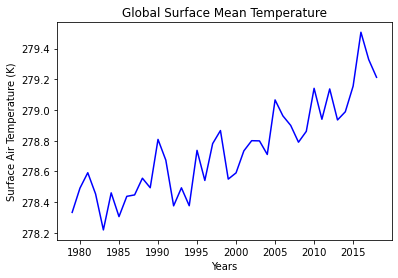

In [29]:
x = range(1979,2019,1)

fig = plt.figure()
plt.plot(x,tas_annualmean_timeseries_v2, 'b-')

plt.title('Global Surface Mean Temperature')
plt.ylabel("Surface Air Temperature (K)")
plt.xlabel("Years")

In [44]:
# Per decade trends

x80s = range(1980,1990,1)
y80s = tas_annualmean_timeseries_v2.sel(year=slice("1980","1989"))

# calc the trendline of 1980s
z80s = np.polyfit(x80s, y80s, 1)
p80s = np.poly1d(z80s)

x90s = range(1990,2000,1)
y90s = tas_annualmean_timeseries_v2.sel(year=slice("1990","1999"))

# calc the trendline of 1990s
z90s = np.polyfit(x90s, y90s, 1)
p90s = np.poly1d(z90s)

x00s = range(2000,2010,1)
y00s = tas_annualmean_timeseries_v2.sel(year=slice("2000","2009"))

# calc the trendline of 2000s
z00s = np.polyfit(x00s, y00s, 1)
p00s = np.poly1d(z00s)

x10s = range(2010,2019,1)
y10s = tas_annualmean_timeseries_v2.sel(year=slice("2010","2018"))

# calc the trendline of 2010s
z10s = np.polyfit(x10s, y10s, 1)
p10s = np.poly1d(z10s)

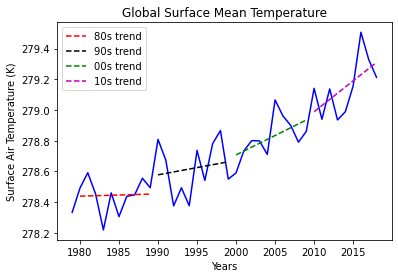

In [53]:
fig = plt.figure()
plt.plot(x,tas_annualmean_timeseries_v2, 'b-')
plt.plot(x80s,p80s(x80s),"r--", label='80s trend')
plt.plot(x90s,p90s(x90s),"k--", label='90s trend')
plt.plot(x00s,p00s(x00s),"g--", label='00s trend')
plt.plot(x10s,p10s(x10s),"m--", label='10s trend')

plt.title('Global Surface Mean Temperature')
plt.ylabel("Surface Air Temperature (K)")
plt.xlabel("Years")

plt.legend()

In [62]:
# Calculate average temperature per trend period

tas_80s_mean = tas_annualmean_timeseries_v2.sel(year=slice("1980","1989")).mean().compute()
print(tas_80s_mean)
tas_90s_mean = tas_annualmean_timeseries_v2.sel(year=slice("1990","1999")).mean().compute()
print(tas_90s_mean)
tas_00s_mean = tas_annualmean_timeseries_v2.sel(year=slice("2000","2009")).mean().compute()
print(tas_00s_mean)
tas_10s_mean = tas_annualmean_timeseries_v2.sel(year=slice("2010","2018")).mean().compute()
print(tas_10s_mean)

<xarray.DataArray 'tas' ()>
array(278.44492, dtype=float32)
<xarray.DataArray 'tas' ()>
array(278.61987, dtype=float32)
<xarray.DataArray 'tas' ()>
array(278.82098, dtype=float32)
<xarray.DataArray 'tas' ()>
array(279.1495, dtype=float32)


In [49]:
# Per 20-yr period trends

x8090s = range(1980,2000,1)
y8090s = tas_annualmean_timeseries_v2.sel(year=slice("1980","1999"))

# calc the trendline of 1980s
z8090s = np.polyfit(x8090s, y8090s, 1)
p8090s = np.poly1d(z8090s)

x9000s = range(1990,2010,1)
y9000s = tas_annualmean_timeseries_v2.sel(year=slice("1990","2009"))

# calc the trendline of 1990s
z9000s = np.polyfit(x9000s, y9000s, 1)
p9000s = np.poly1d(z9000s)

x0010s = range(2000,2019,1)
y0010s = tas_annualmean_timeseries_v2.sel(year=slice("2000","2018"))

# calc the trendline of 2000s
z0010s = np.polyfit(x0010s, y0010s, 1)
p0010s = np.poly1d(z0010s)

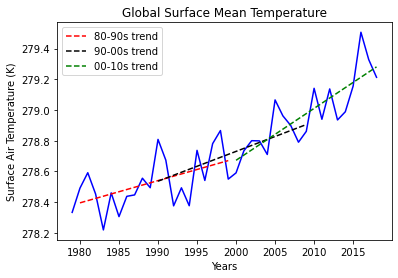

In [54]:
fig = plt.figure()
plt.plot(x,tas_annualmean_timeseries_v2, 'b-')
plt.plot(x8090s,p8090s(x8090s),"r--", label='80-90s trend')
plt.plot(x9000s,p9000s(x9000s),"k--", label='90-00s trend')
plt.plot(x0010s,p0010s(x0010s),"g--", label='00-10s trend')

plt.title('Global Surface Mean Temperature')
plt.ylabel("Surface Air Temperature (K)")
plt.xlabel("Years")

plt.legend()

In [64]:
# Calculate average temperature per trend period

tas_8090s_mean = tas_annualmean_timeseries_v2.sel(year=slice("1980","1999")).mean().compute()
print(tas_8090s_mean)
tas_9000s_mean = tas_annualmean_timeseries_v2.sel(year=slice("1990","2009")).mean().compute()
print(tas_9000s_mean)
tas_0010s_mean = tas_annualmean_timeseries_v2.sel(year=slice("2000","2018")).mean().compute()
print(tas_0010s_mean)

<xarray.DataArray 'tas' ()>
array(278.5324, dtype=float32)
<xarray.DataArray 'tas' ()>
array(278.72043, dtype=float32)
<xarray.DataArray 'tas' ()>
array(278.9766, dtype=float32)


In [55]:
# Per 30-yr period trends

x8000s = range(1980,2010,1)
y8000s = tas_annualmean_timeseries_v2.sel(year=slice("1980","2009"))

# calc the trendline of 1980s
z8000s = np.polyfit(x8000s, y8000s, 1)
p8000s = np.poly1d(z8000s)

x9010s = range(1990,2019,1)
y9010s = tas_annualmean_timeseries_v2.sel(year=slice("1990","2018"))

# calc the trendline of 1990s
z9010s = np.polyfit(x9010s, y9010s, 1)
p9010s = np.poly1d(z9010s)


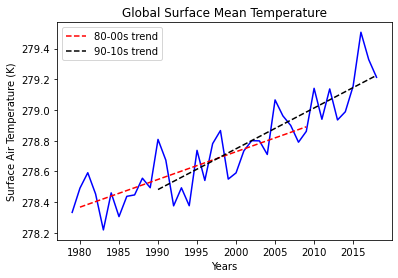

In [56]:
fig = plt.figure()
plt.plot(x,tas_annualmean_timeseries_v2, 'b-')
plt.plot(x8000s,p8000s(x8000s),"r--", label='80-00s trend')
plt.plot(x9010s,p9010s(x9010s),"k--", label='90-10s trend')

plt.title('Global Surface Mean Temperature')
plt.ylabel("Surface Air Temperature (K)")
plt.xlabel("Years")

plt.legend()

In [65]:
# Calculate average temperature per trend period

tas_8000s_mean = tas_annualmean_timeseries_v2.sel(year=slice("1980","2009")).mean().compute()
print(tas_8000s_mean)
tas_9010s_mean = tas_annualmean_timeseries_v2.sel(year=slice("1990","2018")).mean().compute()
print(tas_9010s_mean)


<xarray.DataArray 'tas' ()>
array(278.62857, dtype=float32)
<xarray.DataArray 'tas' ()>
array(278.85358, dtype=float32)


--- Annual Maximum/Minimum Spatial Analysis

In [61]:
# Annual max of tas

tas_annualmax = tas_noleap_all.groupby(tas_noleap_all.time.dt.year).max()

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

In [62]:
tas_annualmax

<xarray.DataArray 'tas' (year: 40, latitude: 721, longitude: 1440)>
dask.array<stack, shape=(40, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018

In [63]:
tas_annualmax.persist()

<xarray.DataArray 'tas' (year: 40, latitude: 721, longitude: 1440)>
dask.array<stack, shape=(40, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018

In [68]:
# tas_annualmax.max().compute()

In [69]:
tas_annualmax_overallmax = tas_annualmax.max(dim='year').compute()

In [67]:
tas_annualmax_overallmax

NameError: name 'tas_annualmax_overallmax' is not defined

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Text(0.5, 1.0, 'Maximum Annual Maximum Temperature')

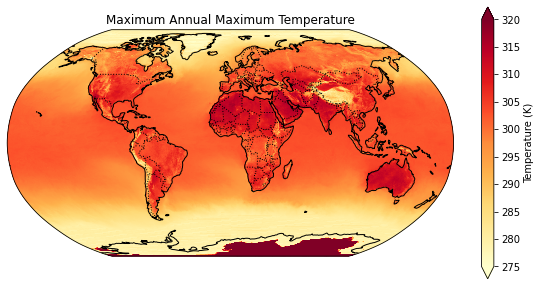

In [76]:
# Plot maximum annual maximums acorss globe

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.YlOrRd #YlGnBu

ax.coastlines()

tas_annualmax_overallmax.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"},
    vmin=275,
    vmax=320,
)

ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("Maximum Annual Maximum Temperature")

In [77]:
# Annual min of tas

tas_annualmin = tas_noleap_all.groupby(tas_noleap_all.time.dt.year).min()

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

In [78]:
tas_annualmin.persist()

<xarray.DataArray 'tas' (year: 40, latitude: 721, longitude: 1440)>
dask.array<stack, shape=(40, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018

In [79]:
tas_annualmin_overallmin = tas_annualmin.min(dim='year').compute()

Text(0.5, 1.0, 'Minimum Annual Minimum Temperature')

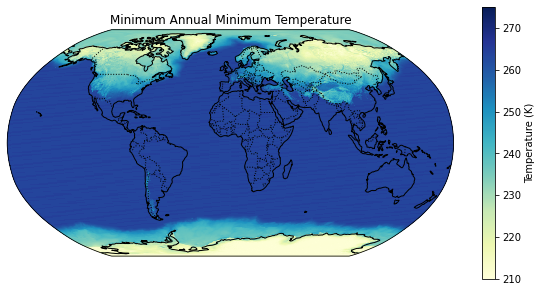

In [84]:
# Plot minimum annual minimums across globe

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.YlGnBu

ax.coastlines()

tas_annualmin_overallmin.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"},
    vmin=210,
    vmax=275,
)

ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("Minimum Annual Minimum Temperature")

--- Calculate 95th and 5th %tile of global surface temperature ---

In [35]:
# Annual 95th of tas

tas_annual95th = tas_noleap_all.groupby(tas_noleap_all.time.dt.year).quantile(0.95)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

In [37]:
tas_annual95th.persist()

<xarray.DataArray 'tas' (year: 40, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(40, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    quantile   float64 0.95
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018

In [12]:
tas_annual95th_mean = tas_annual95th.mean(dim='year').compute()
tas_annual95th_mean

<xarray.DataArray 'tas' (latitude: 721, longitude: 1440)>
array([[273.95908737, 273.95908737, 273.95908737, ..., 273.95922012,
        273.95922012, 273.95922012],
       [273.954272  , 273.95429443, 273.95436356, ..., 273.95399673,
        273.95391739, 273.95382385],
       [273.95025284, 273.95056946, 273.95077026, ..., 273.95083801,
        273.95066849, 273.95050171],
       ...,
       [247.71625061, 247.71534683, 247.70712791, ..., 247.72656952,
        247.72086929, 247.71729965],
       [247.9248275 , 247.92448158, 247.92409172, ..., 247.92524887,
        247.92493843, 247.92462624],
       [249.5324649 , 249.5324649 , 249.5324649 , ..., 249.5324649 ,
        249.5324649 , 249.5324649 ]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    quantile   float64 0.95

Text(0.5, 1.0, 'Mean Annual 95th-%tile Temperature')

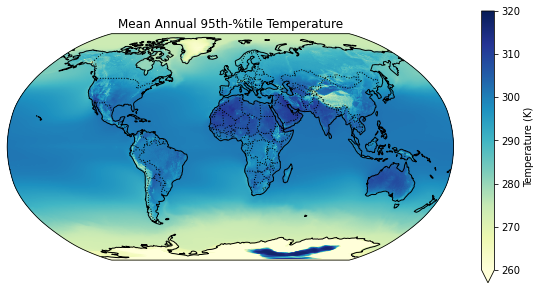

In [15]:
# Plot mean 95th-%tile across globe

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.YlGnBu

ax.coastlines()

tas_annual95th_mean.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"},
    vmin=260,
    vmax=320,
)

ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("Mean Annual 95th-%tile Temperature")

In [44]:
# Annual 5th of tas

tas_annual05th = tas_noleap_all.groupby(tas_noleap_all.time.dt.year).quantile(0.05)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

In [45]:
tas_annual05th.persist()

<xarray.DataArray 'tas' (year: 40, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(40, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    quantile   float64 0.05
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018

In [19]:
tas_annual05th_mean = tas_annual05th.mean(dim='year').compute()
tas_annual05th_mean

<xarray.DataArray 'tas' (latitude: 721, longitude: 1440)>
array([[243.27344498, 243.27344498, 243.27344498, ..., 243.27344498,
        243.27344498, 243.27344498],
       [243.27776031, 243.2780719 , 243.27840004, ..., 243.27738045,
        243.27745483, 243.27763702],
       [243.37440536, 243.37469055, 243.37546272, ..., 243.37379105,
        243.37397179, 243.37417717],
       ...,
       [215.29185165, 215.29537376, 215.29645462, ..., 215.28566376,
        215.29003838, 215.28990967],
       [215.22239235, 215.22555687, 215.21961174, ..., 215.21648354,
        215.21848083, 215.22046638],
       [214.93350517, 214.93350517, 214.93350517, ..., 214.93350517,
        214.93350517, 214.93350517]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    quantile   float64 0.05

Text(0.5, 1.0, 'Mean Annual 05th-%tile Temperature')

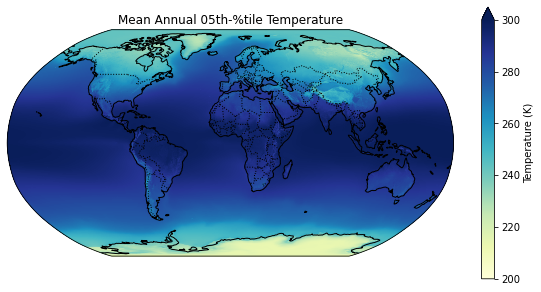

In [53]:
# Plot mean 5th-%tile across globe

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.YlGnBu

ax.coastlines()

tas_annual05th_mean.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"},
    vmin=200,
    vmax=300,
)

ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("Mean Annual 05th-%tile Temperature")

--- Global average 95th %tile ---

In [46]:
tas_annual95th_latavg = tas_annual95th.mean(dim='latitude').persist()

In [47]:
tas_annual95th_timeseries = tas_annual95th_latavg.mean(dim='longitude').persist()

In [48]:
tas_annual95th_timeseries

<xarray.DataArray 'tas' (year: 40)>
dask.array<mean_agg-aggregate, shape=(40,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    quantile  float64 0.95
  * year      (year) int64 1979 1980 1981 1982 1983 ... 2014 2015 2016 2017 2018

Text(0.5, 0, 'Years')

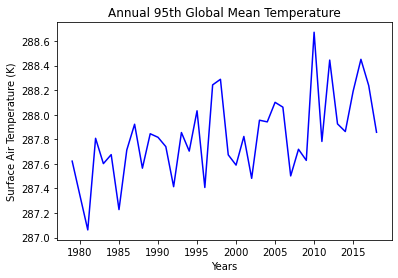

In [43]:
x = range(1979,2019,1)

fig = plt.figure()
plt.plot(x,tas_annual95th_timeseries, 'b-')

plt.title('Annual 95th Global Mean Temperature')
plt.ylabel("Surface Air Temperature (K)")
plt.xlabel("Years")

In [49]:
tas_annual05th_latavg = tas_annual05th.mean(dim='latitude').persist()

In [50]:
tas_annual05th_timeseries = tas_annual05th_latavg.mean(dim='longitude').persist()

In [51]:
tas_annual05th_timeseries

<xarray.DataArray 'tas' (year: 40)>
dask.array<mean_agg-aggregate, shape=(40,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    quantile  float64 0.05
  * year      (year) int64 1979 1980 1981 1982 1983 ... 2014 2015 2016 2017 2018

Text(0.5, 0, 'Years')

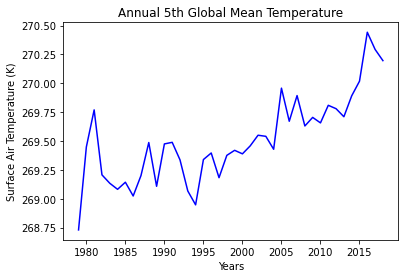

In [52]:
x = range(1979,2019,1)

fig = plt.figure()
plt.plot(x,tas_annual05th_timeseries, 'b-')

plt.title('Annual 5th Global Mean Temperature')
plt.ylabel("Surface Air Temperature (K)")
plt.xlabel("Years")